In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import IPython.display as ipd
import keras
import tensorflow
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.python.keras.utils import np_utils
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
main_path = '/gdrive/MyDrive/Data_Files/'
RAV = os.path.join(main_path, "Audio_Speech_Actors_01-24/")

In [4]:
def get_audio_data(path, calculate_db=False, calculate_mfccs=False, plots=False):
    data, sampling_rate = librosa.load(path, sr=44100)
    Xdb = None
    if calculate_db:
        X = librosa.stft(data)
        Xdb = librosa.amplitude_to_db(abs(X))
    mfccs = None
    if calculate_mfccs:
        mfccs = librosa.feature.mfcc(y = data, sr=sampling_rate, n_mfcc = 40)

    if calculate_db and plots:
        fig, ax = plt.subplots(1,2,figsize=(16, 3))
        plt.subplot(121)
        librosa.display.waveplot(data, sr=sampling_rate)
        plt.subplot(122)
        librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
        plt.show()
    elif plots:
        librosa.display.waveplot(data, sr=sampling_rate)

    return (data, Xdb, mfccs)

In [5]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(RAV)):
  for file in files:
        try:
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[19:20])


            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab)
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)

            full_path.append((root, file))
        except ValueError:
            continue

0it [00:00, ?it/s]

In [6]:
emotions_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])

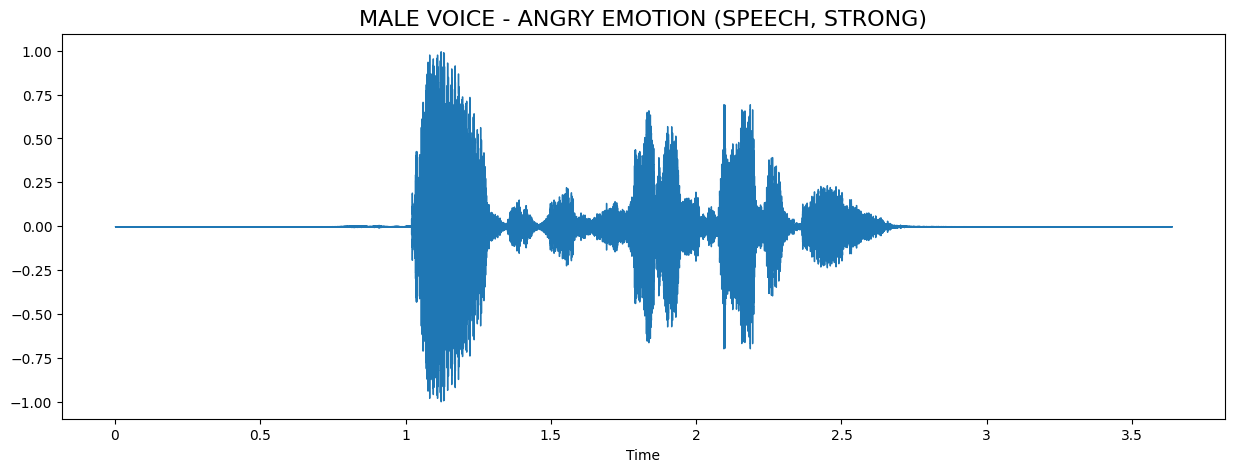

In [9]:
n_files = df.shape[0]


rnd = np.random.randint(0,n_files)


fname = df.path[rnd]
data, sampling_rate = librosa.load(fname, sr=44100)

plt.figure(figsize=(15, 5))
info = df.iloc[rnd].values
title_txt = f'{info[4]} voice - {info[0]} emotion ({info[1]}, {info[3]})'
plt.title(title_txt.upper(), size=16)
librosa.display.waveshow(data, sr=sampling_rate)

ipd.Audio(fname)

In [10]:
df.head()

,emotion,voc_channel,modality,intensity,actors,phrase,path
0,neutral,speech,audio only,normal,female,Dogs are sitting by the door,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...
1,calm,speech,audio only,normal,female,Dogs are sitting by the door,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...
2,neutral,speech,audio only,normal,female,Dogs are sitting by the door,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...
3,calm,speech,audio only,normal,female,Kids are talking by the door,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...
4,neutral,speech,audio only,normal,female,Kids are talking by the door,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...


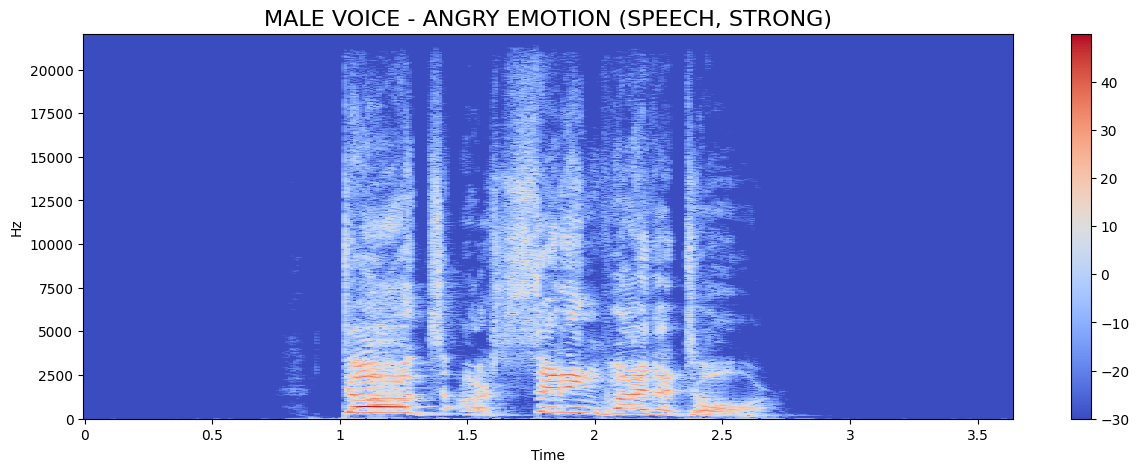

In [11]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title(title_txt.upper(), size=16)
plt.show()

In [12]:
#mfccs = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc = 40)
mfccs = librosa.feature.mfcc(y = data, sr = sampling_rate, n_mfcc = 40)

In [13]:
data.shape, Xdb.shape, mfccs.shape

((160390,), (1025, 314), (40, 314))

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   emotion      1440 non-null   object
 1   voc_channel  1440 non-null   object
 2   modality     1440 non-null   object
 3   intensity    1440 non-null   object
 4   actors       1440 non-null   object
 5   phrase       1440 non-null   object
 6   path         1440 non-null   object
dtypes: object(7)
memory usage: 78.9+ KB


In [16]:
RAV_df = df.copy()

RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

RAV_df.insert(0, "emotion_label", RAV_df.emotion+'_'+RAV_df.actors, True)
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)
RAV_df.head()

<ipython-input-16-34c57637c8b7>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)


,emotion_label,actors,path
0,neutral_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...
1,calm_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...
2,neutral_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...
3,calm_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...
4,neutral_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...


In [17]:
for col in ['emotion_label', 'actors']:
    print('\nColumn values for ', col.upper())
    print(RAV_df[col].value_counts())


Column values for  EMOTION_LABEL
calm_female         96
happy_female        96
sad_female          96
angry_female        96
fearful_female      96
disgust_female      96
surprised_female    96
calm_male           96
happy_male          96
sad_male            96
angry_male          96
fearful_male        96
disgust_male        96
surprised_male      96
neutral_female      48
neutral_male        48
Name: emotion_label, dtype: int64

Column values for  ACTORS
female    720
male      720
Name: actors, dtype: int64


In [18]:
new_labels_dict_comb = {'angry_male':'negative_male', 'angry_female':'negative_female',
                        'calm_male':'neutral_male', 'calm_female':'neutral_female',
                        'disgust_male':'negative_male', 'disgust_female':'negative_female',
                        'fearful_male':'negative_male','fearful_female':'negative_female',
                        'fear_male':'negative_male', 'fear_female':'negative_female',
                        'happy_male':'positive_male', 'happy_female':'positive_female',
                        'neutral_male':'neutral_male', 'neutral_female':'neutral_female',
                        'sad_male':'negative_male', 'sad_female':'negative_female',
                        'surprised_male':'positive_male', 'surprised_female':'positive_female',
                        'surprise_male':'positive_male', 'surprise_female':'positive_female',
                        'Unknown': 'unk'}

RAV_df['Emotion_Type'] = RAV_df['emotion_label'].map(new_labels_dict_comb)
RAV_df.head()

,emotion_label,actors,path,Emotion_Type
0,neutral_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...,neutral_female
1,calm_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...,neutral_female
2,neutral_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...,neutral_female
3,calm_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...,neutral_female
4,neutral_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...,neutral_female


In [19]:
RAV_df.Emotion_Type.value_counts()

negative_female    384
negative_male      384
positive_female    192
positive_male      192
neutral_female     144
neutral_male       144
Name: Emotion_Type, dtype: int64

In [20]:
RAV_df.to_csv(os.path.join(main_path,"speech.csv"), index=False)

In [21]:
import pickle

In [22]:
!pip install livelossplot

In [23]:
import cv2
import pickle
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

[]

In [24]:
def namestr(obj, namespace=globals()):
  return [name for name in namespace if namespace[name] is obj]


def save_pickle(obj, path='/gdrive/MyDrive/Data_Files/Audio_Speech_Actors_01-24/'):
  """
  The function generates filename and saves the file as a pickle object
  """
  dt = datetime.now().strftime("_%d.%m_%H:%M:%S")
  filename = namestr(obj)[0] + dt + '.pickle'

  try:
    pickle.dump(obj, open(os.path.join(path, filename), "wb" ))
    save_path = os.path.join(path, filename)
  except:
    pickle.dump(obj, open(filename, "wb" ))
    save_path = filename

  print(f'File was saved as \"{filename}\"')
  return save_path

In [25]:
def get_audio_data(path, calculate_db=False, calculate_mfccs=False,
                   add_noize=False, add_speed=False, add_shift=False,
                   plots=False):
  """
  Get all data from the audio file
  """
  data, sampling_rate = librosa.load(path, sr=44100)
  Xdb = None

  # adding white noise
  if add_noize:
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])

  # increasing speed
  if add_speed:
    data = data * np.random.uniform(low=1.5,high=4)

  # adding shift
  if add_shift:
    start_ = int(np.random.uniform(-4800,4800))
    if start_ >= 0:
      data = np.r_[data[start_:], np.random.uniform(-0.001,0.001, start_)]
    else:
      data = np.r_[np.random.uniform(-0.001,0.001, -start_), data[:start_]]

  if calculate_db:
      X = librosa.stft(data)
      Xdb = librosa.amplitude_to_db(abs(X))
  mfccs = None

  if calculate_mfccs:
      mfccs = librosa.feature.mfcc(y = data, sr=sampling_rate, n_mfcc = 40)

  if calculate_db and plots:
      fig, ax = plt.subplots(1,2,figsize=(16, 3))
      plt.subplot(121)
      librosa.display.waveplot(data, sr=sampling_rate)
      plt.subplot(122)
      librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
      plt.show()
  elif plots:
      librosa.display.waveplot(data, sr=sampling_rate)

  return (data, Xdb, mfccs)

In [26]:
def pad_array(a, limit):
  assert len(a.shape) == 2
  new_a = a

  if a.shape[1] < limit:
    a_shape = a.shape[1]
    new_a = np.zeros((a.shape[0], limit))
    new_a[:, :a.shape[1]] = a

  elif a.shape[1] > limit:
    new_a = a[:,:limit]

  return new_a

def cut_array(a, limit):
  assert len(a.shape) == 2
  if a.shape[1] > limit:
    a = a[:,:limit]
  return a

def transform_mfccs(arr, transform='pad'):
  list_lengths = [x.shape[1] for x in arr]

  if transform == 'pad':
    limit = int(np.median(list_lengths)) # average length of array
    new_arr = [pad_array(a, limit) for a in arr]
  elif transform == 'cut':
    limit = np.min(list_lengths) # mimimal length of array
    new_arr = [cut_array(a, limit) for a in arr]
  else:
    print("wrong parameter for the transformation")
    return

  new_arr = np.array(new_arr)
  return new_arr

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def report_res_and_plot_matrix(y_test, y_pred, plot_classes):

  #report metrics
  acc = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {acc:.4f}")
  # print(f"Classes: {plot_classes}")

  #plot matrix
  cnf_matrix = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots()

  tick_marks = np.arange(len(plot_classes))
  plt.xticks(ticks=tick_marks, labels=plot_classes, rotation=90)
  plt.yticks(ticks=tick_marks, labels=plot_classes, rotation=90)

  group_counts = [f'{value:0.0f}' for value in cnf_matrix.flatten()]
  group_percentages = [f'{100 * value:0.1f} %' for value in
                       cnf_matrix.flatten()/np.sum(cnf_matrix)]
  labels = [f'{v1}\n({v2})' for v1, v2 in
            zip(group_counts,group_percentages)]
  n = int(np.sqrt(len(labels)))
  labels = np.asarray(labels).reshape(n,n)
  sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

  # return metrics
  return [acc, cnf_matrix]

In [28]:
class DatasetSelector:
  def __init__(self, df, label='Emotion_Type', path='path',
               subclass='actors'):

    self.df = df
    self.label = label
    self.path = path
    self.subclass = subclass

  def select(self, subclass=None, balanced=True, verbose=False):

    df = self.df

    if not subclass is None:
      df = df.loc[(df[self.subclass]==subclass)]

    if balanced:
      label_counts = df[self.label].value_counts().values
      label_names = df[self.label].value_counts().index
      balanced = np.min(label_counts)

      sub_df_list =[]
      for lab in df[self.label].unique():
        sub_df = df.loc[(df[self.label]==lab)]
        sub_df_list.append(sub_df.sample(balanced))

      df = pd.concat(sub_df_list)

    print(f"New shape: {df.shape}")
    if balanced and verbose:
      print(df[self.label].value_counts())

    return df

  def load_mfccs(self, subclass=None, balanced=True,
                 with_noise=False, with_shift=False, with_speed=False):

    df = self.select(subclass, balanced, verbose=True)
    arr_mfccs = []

    print("Extracting of mfccs from the data...")
    for path in tqdm(df[self.path].values):
      a1, a2, a3 = get_audio_data(path, calculate_mfccs=True,
                                  add_noize=with_noise,
                                  add_speed=with_speed,
                                  add_shift=with_shift)
      arr_mfccs.append(a3)


    return (arr_mfccs, df[self.label].values, df[self.path].values)



  def load_melspecs(self, subclass=None, balanced=True,
                    with_noise=False, with_shift=False, with_speed=False):

    df = self.select(subclass, balanced, verbose=True)
    arr_melspec = []

    print("Extracting of mel-spectrograms from the data...")
    for path in tqdm(df[self.path].values):
      a1, a2, a3 = get_audio_data(path, calculate_db=True,
                                  add_noize=with_noise,
                                  add_speed=with_speed,
                                  add_shift=with_shift)
      arr_melspec.append(a2)

    print("Converting of mel-spectrograms to images...")
    arr_melspec_images = []
    for a in tqdm(arr_melspec):
      img = np.stack((a,) * 3,-1)
      img = img.astype(np.uint8)
      grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      grayImage = cv2.resize(grayImage, (224, 224))
      arr_melspec_images.append(grayImage)

    arr_melspec_images = np.array(arr_melspec_images)

    print("All mel-spectrograms were converted successfully")
    print(arr_melspec_images[:][:][0].shape)
    # plt.imshow(grayImage)

    return (arr_melspec_images, df[self.label].values, df[self.path].values)


In [29]:
path0 = os.path.join(main_path, 'speech.csv')

song_df = pd.read_csv(path0)
song_df.head()

,emotion_label,actors,path,Emotion_Type
0,neutral_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...,neutral_female
1,calm_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...,neutral_female
2,neutral_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...,neutral_female
3,calm_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...,neutral_female
4,neutral_female,female,/gdrive/MyDrive/Data_Files/Audio_Speech_Actors...,neutral_female


In [47]:
ds = DatasetSelector(song_df)

In [48]:
import librosa

In [49]:
X, y, check_ = ds.load_mfccs(subclass='female', balanced=False)

New shape: (720, 4)
Extracting of mfccs from the data...


  0%|          | 0/720 [00:00<?, ?it/s]

In [50]:
X = transform_mfccs(X)

In [51]:
save_pickle(X)
save_pickle(y)

File was saved as "X_28.03_04:38:47.pickle"
File was saved as "y_28.03_04:38:47.pickle"


'/gdrive/MyDrive/Data_Files/Audio_Speech_Actors_01-24/y_28.03_04:38:47.pickle'

In [52]:
selected_path = main_path+'Audio_Speech_Actors_01-24/'

X_filename = 'X_28.03_04:38:47.pickle'
y_filename = 'y_28.03_04:38:47.pickle'

with open(selected_path + X_filename, 'rb') as picklefile:
  X = pickle.load(picklefile)
with open(selected_path + y_filename, 'rb') as picklefile:
  y = pickle.load(picklefile)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((576, 40, 320), (144, 40, 320), (576,), (144,))

In [54]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
le.classes_

array(['negative_female', 'neutral_female', 'positive_female'],
      dtype=object)

In [117]:
#MODEL 1 FEMALE
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv1D(64, 10, padding='same', input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))


model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(4))
model.add(tf.keras.layers.Activation('softmax'))

# set callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.5, patience=4,
                                                 verbose=1, mode='max',
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=42,
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'female_model_weights.hdf5'),
                                                      save_weights_only=True,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

model.compile(optimizer=Adam(lr=0.0006), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 40, 64)            197184    
                                                                 
 activation_47 (Activation)  (None, 40, 64)            0         
                                                                 
 dropout_52 (Dropout)        (None, 40, 64)            0         
                                                                 
 max_pooling1d_32 (MaxPooli  (None, 10, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_33 (Conv1D)          (None, 10, 64)            41024     
                                                                 
 activation_48 (Activation)  (None, 10, 64)            0         
                                                     

In [118]:
a, len_a = y_train, len(y_train)
a0 = len(np.where(a == 0)[0])/len_a
a1 = len(np.where(a == 1)[0])/len_a
a2 = len(np.where(a == 2)[0])/len_a

class_weight = {0: a0, 1: a1, 2: a2}

In [120]:
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_split=0.3,
                    callbacks=[early_stop, model_checkpoint, reduce_lr],
                    class_weight=class_weight)

Epoch 1/100
16/16 [==============================] - 1s 56ms/step - loss: 5.6732 - accuracy: 0.5270 - val_loss: 2.7135 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 1s 54ms/step - loss: 1.6869 - accuracy: 0.5394 - val_loss: 1.6969 - val_accuracy: 0.4857 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 1s 46ms/step - loss: 0.8116 - accuracy: 0.5892 - val_loss: 1.3973 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 1s 41ms/step - loss: 0.4554 - accuracy: 0.5685 - val_loss: 1.4482 - val_accuracy: 0.4857 - lr: 0.0010
Epoch 5/100
15/16 [===========================>..] - ETA: 0s - loss: 0.3871 - accuracy: 0.5750
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16/16 [==============================] - 1s 35ms/step - loss: 0.3868 - accuracy: 0.5726 - val_loss: 1.2044 - val_accuracy: 0.4857 - lr: 0.0010
Epoch 6/100
16/16 [==============================] - 1s 50ms/step 

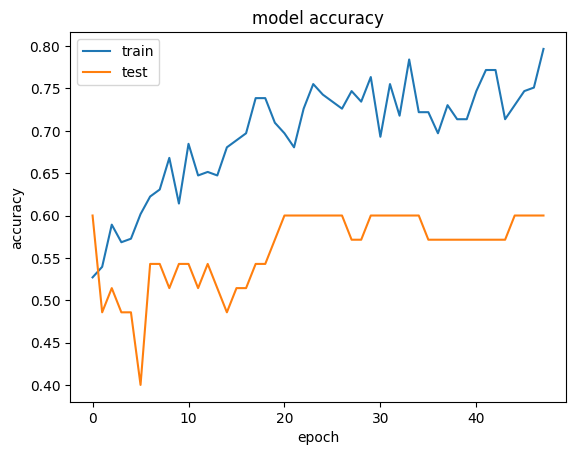

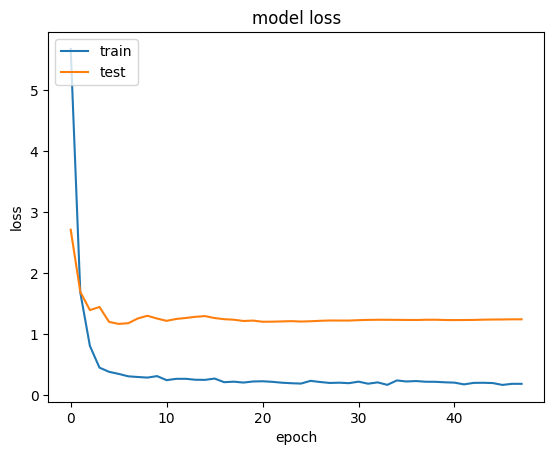

In [121]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [122]:
#MODEL 2 FEMALE

model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.Conv1D(64, 10, padding='same', input_shape=X_train.shape[1:]))
model2.add(tf.keras.layers.Activation('relu'))
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

#model.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
#model.add(tf.keras.layers.Activation('relu'))
#model.add(tf.keras.layers.Dropout(0.1))
#model.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))


model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dense(256))
model2.add(tf.keras.layers.Dropout(0.2))

model2.add(tf.keras.layers.Dense(128))
model2.add(tf.keras.layers.Dropout(0.1))

model2.add(tf.keras.layers.Dense(4))
model2.add(tf.keras.layers.Activation('softmax'))

# set callbacks
reduce_lr1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.5, patience=4,
                                                 verbose=1, mode='max',
                                                 min_lr=0.00001)

early_stop1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=42,
                                              verbose=1)

model2_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'female_model_weights.hdf5'),
                                                      save_weights_only=True,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

model2.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_34 (Conv1D)          (None, 40, 64)            197184    
                                                                 
 activation_50 (Activation)  (None, 40, 64)            0         
                                                                 
 dropout_56 (Dropout)        (None, 40, 64)            0         
                                                                 
 max_pooling1d_34 (MaxPooli  (None, 10, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_16 (Flatten)        (None, 640)               0         
                                                                 
 dense_48 (Dense)            (None, 256)               164096    
                                                     

In [63]:
a, len_a = y_train, len(y_train)
a0 = len(np.where(a == 0)[0])/len_a
a1 = len(np.where(a == 1)[0])/len_a
a2 = len(np.where(a == 2)[0])/len_a

class_weight = {0: a0, 1: a1, 2: a2}

In [123]:
history2 = model2.fit(X_train, y_train, batch_size=16, epochs=100, validation_split=0.3,
                    callbacks=[early_stop1, model2_checkpoint, reduce_lr1],
                    class_weight=class_weight)

Epoch 1/100
16/16 [==============================] - 2s 49ms/step - loss: 133.6256 - accuracy: 0.3361 - val_loss: 118.2722 - val_accuracy: 0.5096 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 0s 26ms/step - loss: 49.3678 - accuracy: 0.4647 - val_loss: 131.4928 - val_accuracy: 0.5481 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 0s 24ms/step - loss: 37.7588 - accuracy: 0.5311 - val_loss: 79.3480 - val_accuracy: 0.4808 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 0s 23ms/step - loss: 22.6053 - accuracy: 0.6058 - val_loss: 57.8859 - val_accuracy: 0.3942 - lr: 0.0010
Epoch 5/100
16/16 [==============================] - 0s 23ms/step - loss: 11.0406 - accuracy: 0.6639 - val_loss: 45.4516 - val_accuracy: 0.4423 - lr: 0.0010
Epoch 6/100
15/16 [===========================>..] - ETA: 0s - loss: 3.4717 - accuracy: 0.7875
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16/16 [==============================] - 

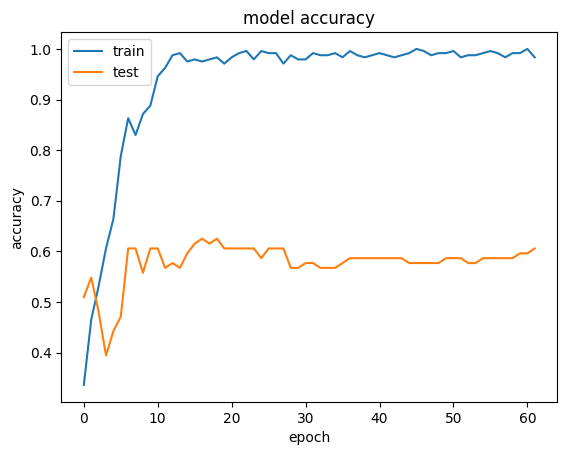

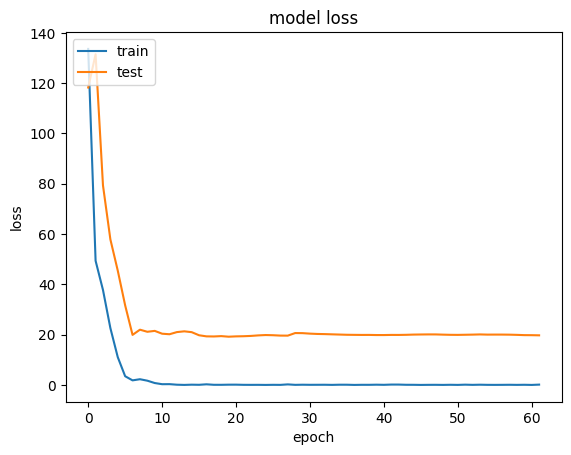

In [124]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [125]:
#MODEL 3 FEMALE
model3 = tf.keras.models.Sequential()

model3.add(tf.keras.layers.Conv1D(64, 10, padding='same', input_shape=X_train.shape[1:]))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.1))
model3.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model3.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
model3.add(tf.keras.layers.Activation('relu'))
model3.add(tf.keras.layers.Dropout(0.1))
model3.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

#model3.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
#model3.add(tf.keras.layers.Activation('relu'))
#model3.add(tf.keras.layers.Dropout(0.1))
#model3.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))


model3.add(tf.keras.layers.Flatten())

model3.add(tf.keras.layers.Dense(256))
model3.add(tf.keras.layers.Dropout(0.2))

model3.add(tf.keras.layers.Dense(128))
model3.add(tf.keras.layers.Dropout(0.1))

model3.add(tf.keras.layers.Dense(4))
model3.add(tf.keras.layers.Activation('softmax'))

# set callbacks
reduce_lr3 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.5, patience=4,
                                                 verbose=1, mode='max',
                                                 min_lr=0.00001)

early_stop3 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=42,
                                              verbose=1)

model_checkpoint3 = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'female_model_weights.hdf5'),
                                                      save_weights_only=True,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

model3.compile(optimizer=Adam(lr=0.000000006), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 40, 64)            197184    
                                                                 
 activation_52 (Activation)  (None, 40, 64)            0         
                                                                 
 dropout_59 (Dropout)        (None, 40, 64)            0         
                                                                 
 max_pooling1d_35 (MaxPooli  (None, 10, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_36 (Conv1D)          (None, 10, 64)            41024     
                                                                 
 activation_53 (Activation)  (None, 10, 64)            0         
                                                     

In [126]:
a, len_a = y_train, len(y_train)
a0 = len(np.where(a == 0)[0])/len_a
a1 = len(np.where(a == 1)[0])/len_a
a2 = len(np.where(a == 2)[0])/len_a

class_weight = {0: a0, 1: a1, 2: a2}

In [128]:
history3 = model3.fit(X_train, y_train, batch_size=16, epochs=100, validation_split=0.1,
                    callbacks=[early_stop3, model_checkpoint3, reduce_lr3],
                    class_weight=class_weight)

Epoch 1/100
20/20 [==============================] - 1s 72ms/step - loss: 0.2660 - accuracy: 0.7387 - val_loss: 1.7552 - val_accuracy: 0.5714 - lr: 1.0000e-05
Epoch 2/100
20/20 [==============================] - 1s 42ms/step - loss: 0.2453 - accuracy: 0.7355 - val_loss: 1.7384 - val_accuracy: 0.5714 - lr: 1.0000e-05
Epoch 3/100
20/20 [==============================] - 1s 44ms/step - loss: 0.2301 - accuracy: 0.7548 - val_loss: 1.7290 - val_accuracy: 0.5714 - lr: 1.0000e-05
Epoch 4/100
20/20 [==============================] - 1s 36ms/step - loss: 0.2182 - accuracy: 0.7419 - val_loss: 1.7344 - val_accuracy: 0.5714 - lr: 1.0000e-05
Epoch 5/100
20/20 [==============================] - 1s 58ms/step - loss: 0.2515 - accuracy: 0.7129 - val_loss: 1.7206 - val_accuracy: 0.6000 - lr: 1.0000e-05
Epoch 6/100
20/20 [==============================] - 0s 22ms/step - loss: 0.2019 - accuracy: 0.7548 - val_loss: 1.7229 - val_accuracy: 0.5714 - lr: 1.0000e-05
Epoch 7/100
20/20 [===========================

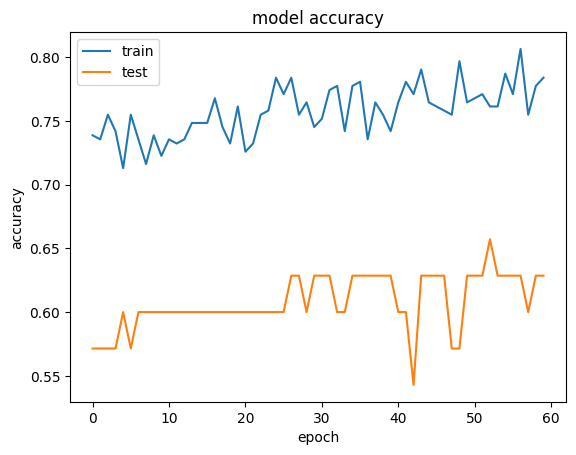

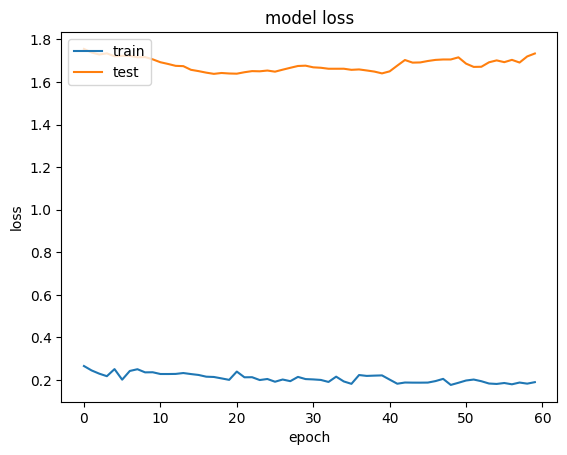

In [129]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [130]:
#MODEL 4 FEMALE
model4 = tf.keras.models.Sequential()

model4.add(tf.keras.layers.Conv1D(64, 10, padding='same', input_shape=X_train.shape[1:]))
model4.add(tf.keras.layers.Activation('relu'))
model4.add(tf.keras.layers.Dropout(0.1))
model4.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

#model4.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
#model4.add(tf.keras.layers.Activation('relu'))
#model4.add(tf.keras.layers.Dropout(0.1))
#model4.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

#model4.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
#model4.add(tf.keras.layers.Activation('relu'))
#model4.add(tf.keras.layers.Dropout(0.1))
#model4.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))

#model4.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
#model4.add(tf.keras.layers.Activation('relu'))
#model4.add(tf.keras.layers.Dropout(0.1))
#model4.add(tf.keras.layers.MaxPooling1D(pool_size=(1)))


model4.add(tf.keras.layers.Flatten())

model4.add(tf.keras.layers.Dense(256))
model4.add(tf.keras.layers.Dropout(0.2))

model4.add(tf.keras.layers.Dense(128))
model4.add(tf.keras.layers.Dropout(0.1))

model4.add(tf.keras.layers.Dense(4))
model4.add(tf.keras.layers.Activation('softmax'))

# set callbacks
reduce_lr4 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.5, patience=4,
                                                 verbose=1, mode='max',
                                                 min_lr=0.00001)

early_stop4 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=42,
                                              verbose=1)

model4_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'female_model_weights.hdf5'),
                                                      save_weights_only=True,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

model4.compile(optimizer=Adam(lr=0.0000000006), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_37 (Conv1D)          (None, 40, 64)            197184    
                                                                 
 activation_55 (Activation)  (None, 40, 64)            0         
                                                                 
 dropout_63 (Dropout)        (None, 40, 64)            0         
                                                                 
 max_pooling1d_37 (MaxPooli  (None, 10, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_18 (Flatten)        (None, 640)               0         
                                                                 
 dense_54 (Dense)            (None, 256)               164096    
                                                     

In [131]:
a, len_a = y_train, len(y_train)
a0 = len(np.where(a == 0)[0])/len_a
a1 = len(np.where(a == 1)[0])/len_a
a2 = len(np.where(a == 2)[0])/len_a

class_weight = {0: a0, 1: a1, 2: a2}

In [132]:
history4 = model4.fit(X_train, y_train, batch_size=16, epochs=100, validation_split=0.1,
                    callbacks=[early_stop4, model4_checkpoint, reduce_lr4],
                    class_weight=class_weight)

Epoch 1/100
20/20 [==============================] - 2s 42ms/step - loss: 90.4314 - accuracy: 0.3968 - val_loss: 60.0693 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 0s 23ms/step - loss: 24.4090 - accuracy: 0.5258 - val_loss: 32.5728 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 0s 22ms/step - loss: 10.6187 - accuracy: 0.6452 - val_loss: 64.9535 - val_accuracy: 0.3714 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 0s 22ms/step - loss: 6.5928 - accuracy: 0.6871 - val_loss: 39.2764 - val_accuracy: 0.4857 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - 1s 39ms/step - loss: 4.0447 - accuracy: 0.7452 - val_loss: 34.7094 - val_accuracy: 0.6286 - lr: 0.0010
Epoch 6/100
20/20 [==============================] - 1s 38ms/step - loss: 2.5474 - accuracy: 0.8290 - val_loss: 22.3038 - val_accuracy: 0.5429 - lr: 0.0010
Epoch 7/100
20/20 [==============================] - 1s 35ms/

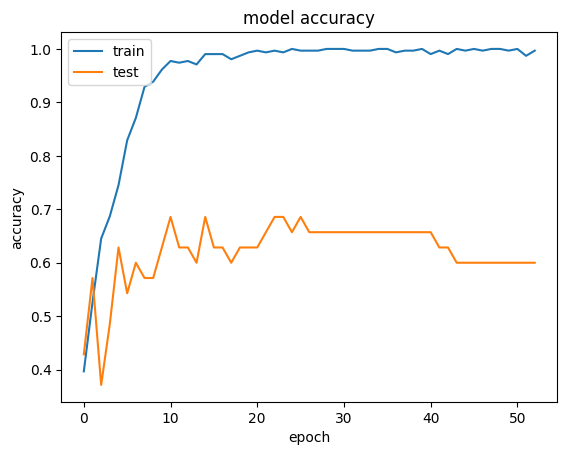

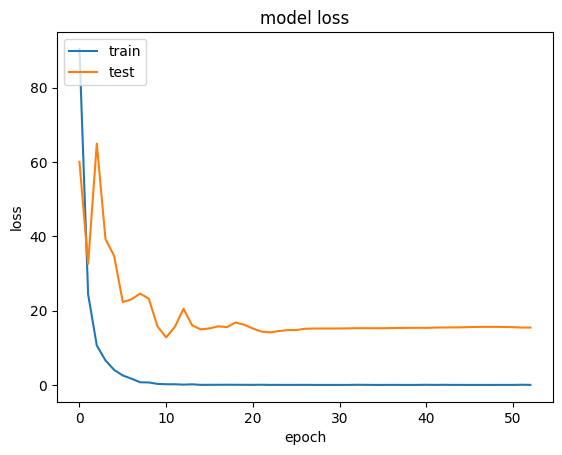

In [133]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [134]:
X, y, check_ = ds.load_mfccs(subclass='male', balanced=True, with_noise=True)

New shape: (432, 4)
neutral_male     144
positive_male    144
negative_male    144
Name: Emotion_Type, dtype: int64
Extracting of mfccs from the data...


  0%|          | 0/432 [00:00<?, ?it/s]

In [135]:
X = transform_mfccs(X)

In [136]:
save_pickle(X)
save_pickle(y)

File was saved as "X_28.03_06:39:11.pickle"
File was saved as "y_28.03_06:39:11.pickle"


'/gdrive/MyDrive/Data_Files/Audio_Speech_Actors_01-24/y_28.03_06:39:11.pickle'

In [137]:
selected_path = main_path+'Audio_Speech_Actors_01-24/'

X_filename = 'X_28.03_06:39:11.pickle'
y_filename = 'y_28.03_06:39:11.pickle'

with open(selected_path + X_filename, 'rb') as picklefile:
  X = pickle.load(picklefile)
with open(selected_path + y_filename, 'rb') as picklefile:
  y = pickle.load(picklefile)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((345, 40, 308), (87, 40, 308), (345,), (87,))

In [139]:
le1 = LabelEncoder()
y_train = le1.fit_transform(y_train)
y_test = le1.transform(y_test)
le1.classes_

array(['negative_male', 'neutral_male', 'positive_male'], dtype=object)

In [140]:
model_1 = tf.keras.models.Sequential()

model_1.add(tf.keras.layers.Conv1D(64, 10, padding='same', input_shape=X_train.shape[1:]))
model_1.add(tf.keras.layers.Activation('relu'))
model_1.add(tf.keras.layers.Dropout(0.3))
model_1.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model_1.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
model_1.add(tf.keras.layers.Activation('relu'))
model_1.add(tf.keras.layers.Dropout(0.001))
model_1.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model_1.add(tf.keras.layers.Flatten())

model_1.add(tf.keras.layers.Dense(128))

model_1.add(tf.keras.layers.Dense(64))

model_1.add(tf.keras.layers.Dense(4))
model_1.add(tf.keras.layers.Activation('softmax'))

# set callbacks
reduce_lr_1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.5, patience=2,
                                                 verbose=1, mode='max',
                                                 min_lr=0.00001)

early_stop_1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,
                                              verbose=1)

model_1_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'male_model_weights.hdf5'),
                                                      save_weights_only=True,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

model_1.compile(optimizer=Adam(lr=0.0006), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_1.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_38 (Conv1D)          (None, 40, 64)            197184    
                                                                 
 activation_57 (Activation)  (None, 40, 64)            0         
                                                                 
 dropout_66 (Dropout)        (None, 40, 64)            0         
                                                                 
 max_pooling1d_38 (MaxPooli  (None, 10, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_39 (Conv1D)          (None, 10, 64)            41024     
                                                                 
 activation_58 (Activation)  (None, 10, 64)            0         
                                                     

In [141]:
a, len_a = y_train, len(y_train)
a0 = len(np.where(a == 0)[0])/len_a
a1 = len(np.where(a == 1)[0])/len_a
a2 = len(np.where(a == 2)[0])/len_a
class_weight = {0: a0, 1: a1, 2: a2}

In [142]:
history_1 = model_1.fit(X_train, y_train, batch_size=18, epochs=100, validation_split=0.3,
                    callbacks=[early_stop_1, model_1_checkpoint, reduce_lr_1],
                    class_weight=class_weight)

Epoch 1/100
14/14 [==============================] - 2s 57ms/step - loss: 85.2593 - accuracy: 0.3568 - val_loss: 132.6214 - val_accuracy: 0.3462 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - 0s 31ms/step - loss: 21.6179 - accuracy: 0.4523 - val_loss: 18.5779 - val_accuracy: 0.4904 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - 0s 26ms/step - loss: 12.2307 - accuracy: 0.5436 - val_loss: 49.7678 - val_accuracy: 0.3654 - lr: 0.0010
Epoch 4/100
14/14 [==============================] - 0s 30ms/step - loss: 9.0630 - accuracy: 0.5643 - val_loss: 14.3343 - val_accuracy: 0.5865 - lr: 0.0010
Epoch 5/100
14/14 [==============================] - 0s 28ms/step - loss: 4.8372 - accuracy: 0.6722 - val_loss: 27.8138 - val_accuracy: 0.4519 - lr: 0.0010
Epoch 6/100
14/14 [==============================] - 0s 29ms/step - loss: 5.9469 - accuracy: 0.6141 - val_loss: 6.7729 - val_accuracy: 0.6346 - lr: 0.0010
Epoch 7/100
14/14 [==============================] - 0s 28ms/

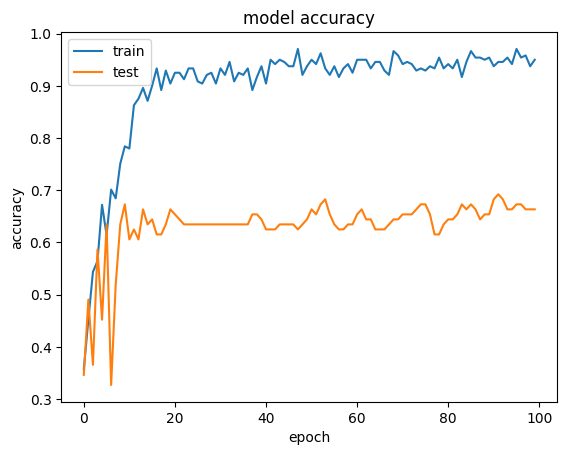

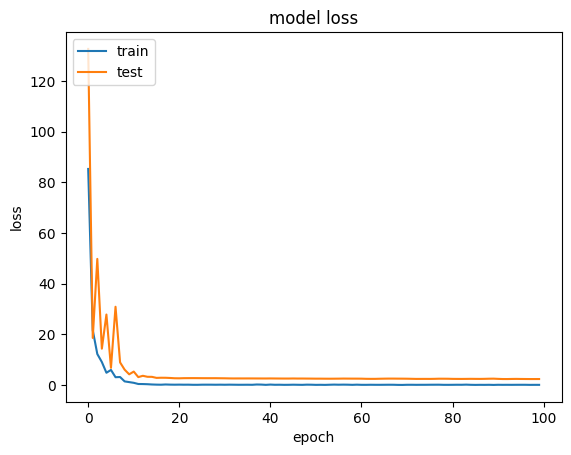

In [143]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [144]:
#model 2 male
model_2 = tf.keras.models.Sequential()

model_2.add(tf.keras.layers.Conv1D(64, 10, padding='same', input_shape=X_train.shape[1:]))
model_2.add(tf.keras.layers.Activation('relu'))
model_2.add(tf.keras.layers.Dropout(0.3))
model_2.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

#model_1.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
#model_1.add(tf.keras.layers.Activation('relu'))
#model_1.add(tf.keras.layers.Dropout(0.001))
#model_1.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model_2.add(tf.keras.layers.Flatten())

model_2.add(tf.keras.layers.Dense(128))

model_2.add(tf.keras.layers.Dense(64))

model_2.add(tf.keras.layers.Dense(4))
model_2.add(tf.keras.layers.Activation('softmax'))

# set callbacks
reduce_lr_2 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.5, patience=2,
                                                 verbose=1, mode='max',
                                                 min_lr=0.00001)

early_stop_2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,
                                              verbose=1)

model_2_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'male_model_weights.hdf5'),
                                                      save_weights_only=True,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

model_2.compile(optimizer=Adam(lr=0.00000000001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_40 (Conv1D)          (None, 40, 64)            197184    
                                                                 
 activation_60 (Activation)  (None, 40, 64)            0         
                                                                 
 dropout_68 (Dropout)        (None, 40, 64)            0         
                                                                 
 max_pooling1d_40 (MaxPooli  (None, 10, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_20 (Flatten)        (None, 640)               0         
                                                                 
 dense_60 (Dense)            (None, 128)               82048     
                                                     

In [145]:
a, len_a = y_train, len(y_train)
a0 = len(np.where(a == 0)[0])/len_a
a1 = len(np.where(a == 1)[0])/len_a
a2 = len(np.where(a == 2)[0])/len_a
class_weight = {0: a0, 1: a1, 2: a2}

In [146]:
history_2 = model_2.fit(X_train, y_train, batch_size=18, epochs=100, validation_split=0.1,
                    callbacks=[early_stop_2, model_2_checkpoint, reduce_lr_2],
                    class_weight=class_weight)

Epoch 1/100
18/18 [==============================] - 2s 48ms/step - loss: 145.0860 - accuracy: 0.3645 - val_loss: 163.7916 - val_accuracy: 0.3143 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 0s 23ms/step - loss: 27.6592 - accuracy: 0.5613 - val_loss: 18.3478 - val_accuracy: 0.8286 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 0s 23ms/step - loss: 10.8542 - accuracy: 0.6161 - val_loss: 14.7050 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 5.2713 - accuracy: 0.6979
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
18/18 [==============================] - 0s 22ms/step - loss: 5.0410 - accuracy: 0.7065 - val_loss: 22.4352 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 0s 22ms/step - loss: 1.9313 - accuracy: 0.7710 - val_loss: 13.1902 - val_accuracy: 0.6857 - lr: 5.0000e-04
Epoch 6/100
16/18 [=========================>....] -

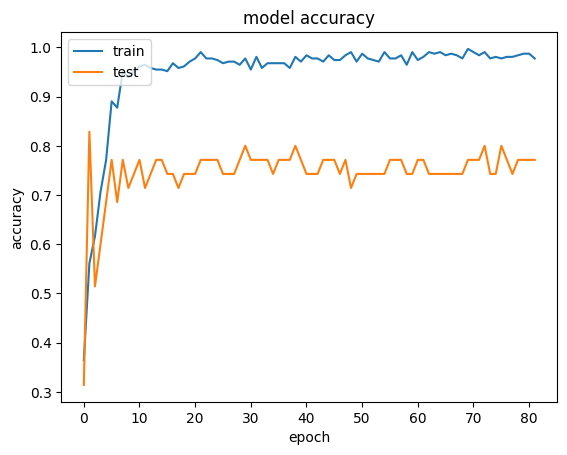

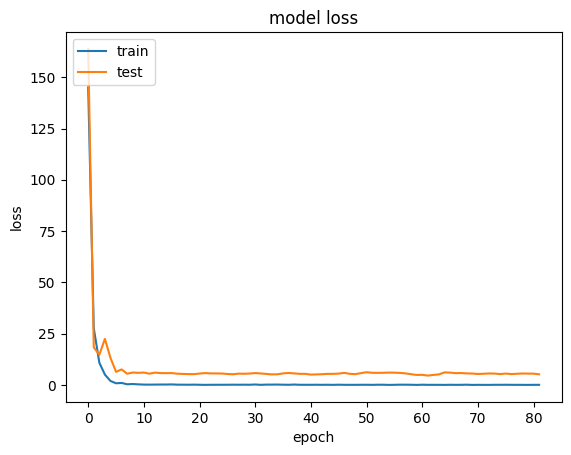

In [147]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [148]:
#model 3 male
model_3 = tf.keras.models.Sequential()

model_3.add(tf.keras.layers.Conv1D(64, 10, padding='same', input_shape=X_train.shape[1:]))
model_3.add(tf.keras.layers.Activation('relu'))
model_3.add(tf.keras.layers.Dropout(0.3))
model_3.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model_3.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
model_3.add(tf.keras.layers.Activation('relu'))
model_3.add(tf.keras.layers.Dropout(0.001))
model_3.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model_3.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
model_3.add(tf.keras.layers.Activation('relu'))
model_3.add(tf.keras.layers.Dropout(0.001))
model_3.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))

model_3.add(tf.keras.layers.Flatten())

model_3.add(tf.keras.layers.Dense(128))

model_3.add(tf.keras.layers.Dense(64))

model_3.add(tf.keras.layers.Dense(4))
model_3.add(tf.keras.layers.Activation('softmax'))

# set callbacks
reduce_lr_3 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.5, patience=2,
                                                 verbose=1, mode='max',
                                                 min_lr=0.00001)

early_stop_3 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,
                                              verbose=1)

model_3_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'male_model_weights.hdf5'),
                                                      save_weights_only=True,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

model_3.compile(optimizer=Adam(lr=0.0000000000000001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_3.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_41 (Conv1D)          (None, 40, 64)            197184    
                                                                 
 activation_62 (Activation)  (None, 40, 64)            0         
                                                                 
 dropout_69 (Dropout)        (None, 40, 64)            0         
                                                                 
 max_pooling1d_41 (MaxPooli  (None, 10, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_42 (Conv1D)          (None, 10, 64)            41024     
                                                                 
 activation_63 (Activation)  (None, 10, 64)            0         
                                                     

In [149]:
a, len_a = y_train, len(y_train)
a0 = len(np.where(a == 0)[0])/len_a
a1 = len(np.where(a == 1)[0])/len_a
a2 = len(np.where(a == 2)[0])/len_a
class_weight = {0: a0, 1: a1, 2: a2}

In [150]:
history_3 = model_3.fit(X_train, y_train, batch_size=18, epochs=100, validation_split=0.3,
                    callbacks=[early_stop_3, model_3_checkpoint, reduce_lr_3],
                    class_weight=class_weight)

Epoch 1/100
14/14 [==============================] - 2s 64ms/step - loss: 17.7970 - accuracy: 0.3527 - val_loss: 23.6290 - val_accuracy: 0.4327 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - 0s 31ms/step - loss: 5.3792 - accuracy: 0.4315 - val_loss: 13.9145 - val_accuracy: 0.5288 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - 0s 32ms/step - loss: 2.9442 - accuracy: 0.4689 - val_loss: 3.3224 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 4/100
14/14 [==============================] - 0s 35ms/step - loss: 1.3370 - accuracy: 0.5602 - val_loss: 1.2029 - val_accuracy: 0.5769 - lr: 0.0010
Epoch 5/100
14/14 [==============================] - 0s 30ms/step - loss: 1.1278 - accuracy: 0.5436 - val_loss: 1.5087 - val_accuracy: 0.5865 - lr: 0.0010
Epoch 6/100
14/14 [==============================] - 0s 30ms/step - loss: 0.6685 - accuracy: 0.5685 - val_loss: 1.1574 - val_accuracy: 0.5192 - lr: 0.0010
Epoch 7/100
13/14 [==========================>...] - ETA: 0s - loss

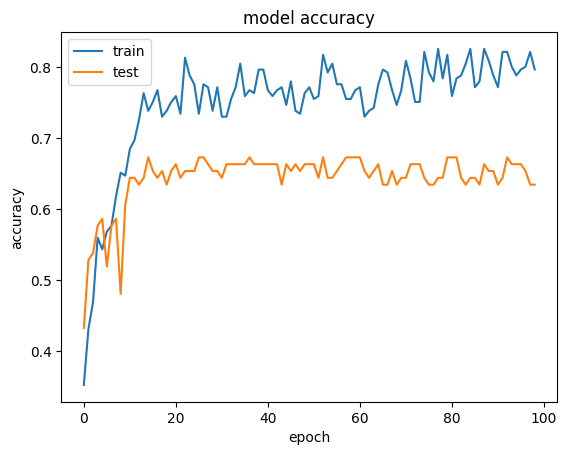

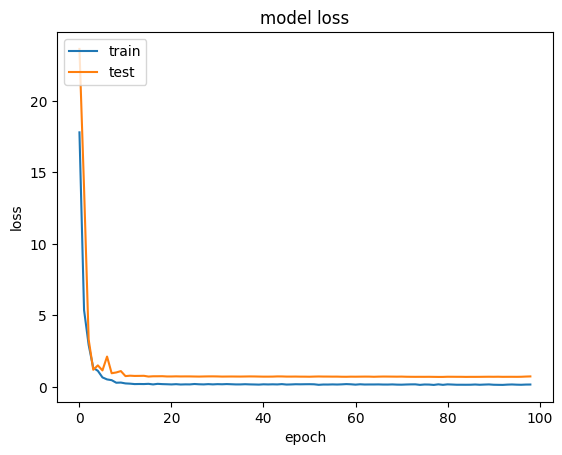

In [151]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [152]:
#MODEL 4 MALE
model_4 = tf.keras.models.Sequential()

model_4.add(tf.keras.layers.Conv1D(64, 10, padding='same', input_shape=X_train.shape[1:]))
model_4.add(tf.keras.layers.Activation('relu'))
model_4.add(tf.keras.layers.Dropout(0.3))
model_4.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))


model_4.add(tf.keras.layers.Flatten())

model_4.add(tf.keras.layers.Dense(128))

model_4.add(tf.keras.layers.Dense(64))

model_4.add(tf.keras.layers.Dense(4))
model_4.add(tf.keras.layers.Activation('softmax'))

# set callbacks
reduce_lr_4 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.5, patience=2,
                                                 verbose=1, mode='max',
                                                 min_lr=0.00001)

early_stop_4 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,
                                              verbose=1)

model_4_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'male_model_weights.hdf5'),
                                                      save_weights_only=True,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

model_4.compile(optimizer=Adam(lr=0.0000000001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_4.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_44 (Conv1D)          (None, 40, 64)            197184    
                                                                 
 activation_66 (Activation)  (None, 40, 64)            0         
                                                                 
 dropout_72 (Dropout)        (None, 40, 64)            0         
                                                                 
 max_pooling1d_44 (MaxPooli  (None, 10, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_22 (Flatten)        (None, 640)               0         
                                                                 
 dense_66 (Dense)            (None, 128)               82048     
                                                     

In [153]:
a, len_a = y_train, len(y_train)
a0 = len(np.where(a == 0)[0])/len_a
a1 = len(np.where(a == 1)[0])/len_a
a2 = len(np.where(a == 2)[0])/len_a
class_weight = {0: a0, 1: a1, 2: a2}

In [154]:
history_4 = model_4.fit(X_train, y_train, batch_size=18, epochs=100, validation_split=0.1,
                    callbacks=[early_stop_4, model_4_checkpoint, reduce_lr_4],
                    class_weight=class_weight)

Epoch 1/100
18/18 [==============================] - 2s 45ms/step - loss: 55.5468 - accuracy: 0.4129 - val_loss: 30.1217 - val_accuracy: 0.6857 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 0s 21ms/step - loss: 18.2361 - accuracy: 0.5806 - val_loss: 33.0002 - val_accuracy: 0.6571 - lr: 0.0010
Epoch 3/100
16/18 [=========================>....] - ETA: 0s - loss: 10.9661 - accuracy: 0.6007
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
18/18 [==============================] - 0s 22ms/step - loss: 10.6174 - accuracy: 0.6032 - val_loss: 21.4406 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 0s 23ms/step - loss: 3.1169 - accuracy: 0.7613 - val_loss: 13.0384 - val_accuracy: 0.6571 - lr: 5.0000e-04
Epoch 5/100
16/18 [=========================>....] - ETA: 0s - loss: 2.1687 - accuracy: 0.8021
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
18/18 [==============================]

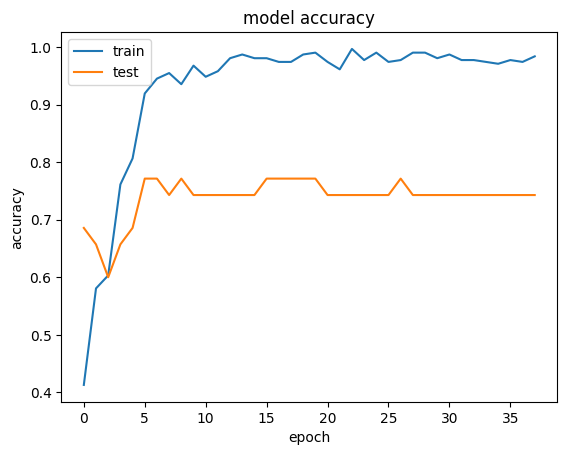

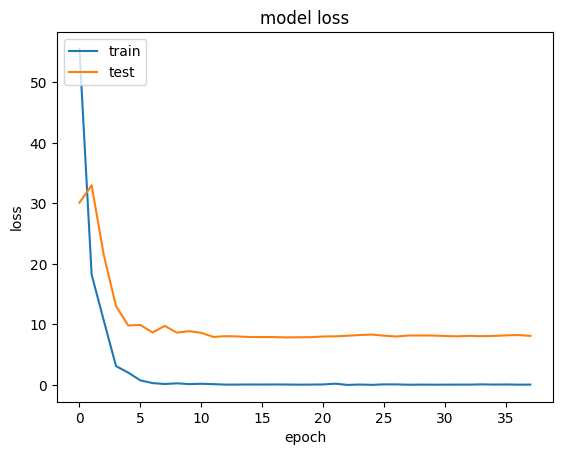

In [155]:
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()